## Exercise 5: Geospatial wrangling and making maps

Skills: 
* More geospatial practice building on earlier skills
* Make a map with `geopandas`

References: 
* https://docs.calitp.org/data-infra/analytics_new_analysts/02-data-analysis-intermediate.html
* https://docs.calitp.org/data-infra/analytics_tools/python_libraries.html

In [1]:
import geopandas as gpd
import intake
import os
import pandas as pd
import shapely

os.environ["CALITP_BQ_MAX_BYTES"] = str(100_000_000_000)

from calitp_data_analysis.tables import tbls
from siuba import *

# Hint: if this doesn't import: refer to docs for correctly import
# cd into _shared_utils folder, run the make setup_env command
import shared_utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_362/2144877482.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling P

## Research Question

What's the average number of trips per stop by operators in southern California? Show visualizations at the operator and county-level.
<br>**Geographic scope:** southern California counties
<br>**Deliverables:** chart(s) and map(s) showing metrics comparing across counties and also across operators. Make these visualizations using function(s).

### Prep data

* Use the same query, but grab a different set of operators. These are in southern California, so the map should zoom in counties ranging from LA to SD.
* *Hint*: for some counties, there are multiple operators. Make sure the average trips per stop by counties is the weighted average.
* Use the same [shapefile for CA counties](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-county-boundaries/explore?location=37.246136%2C-119.002032%2C6.12) as in Exercise 4.
* Join the data and only keep counties that have bus stops.

In [2]:
#retuns df of name to feed_keys

feeds_to_names = shared_utils.gtfs_utils_v2.schedule_daily_feed_to_gtfs_dataset_name(
    selected_date = "2022-06-01",
    get_df = True
)[["feed_key", "name"]].drop_duplicates()

print(type(feeds_to_names))
print(feeds_to_names.shape)
print(feeds_to_names.name.value_counts())
feeds_to_names.head()

<class 'pandas.core.frame.DataFrame'>
(200, 2)
Kern Schedule                     1
Mendocino Schedule                1
StaRTA Schedule                   1
Lynwood Schedule                  1
Merced GMV Schedule               1
                                 ..
Rio Vista Schedule                1
Bay Area 511 SolTrans Schedule    1
SunLine Schedule                  1
Baldwin Park Schedule             1
Alhambra Schedule                 1
Name: name, Length: 200, dtype: int64


,feed_key,name
0,5efaa2460085a481db5dfbf57ae78187,Kern Schedule
1,c50220b8622624dfa0c5c22859b14694,Humboldt Schedule
2,1b77ef49f5bc70038cbf15e4f5f98477,Compton Schedule
3,4b6b673ab50c016344c1adf09de2cc84,Banning Pass Schedule
4,7a7e9069dedca7a58e5a89aaa0a97256,Bay Area 511 Santa Rosa CityBus Schedule


In [3]:
#also brining in CA Counties from ex 4.

ca_county = gpd.read_file('https://services1.arcgis.com/jUJYIo9tSA7EHvfZ/arcgis/rest/services/California_County_Boundaries/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson')
print(type(ca_county))
print(ca_county.shape)
print(ca_county.crs)
ca_county.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(69, 11)
EPSG:4326


,OBJECTID,COUNTY_NAME,COUNTY_ABBREV,COUNTY_NUM,COUNTY_CODE,COUNTY_FIPS,ISLAND,Shape__Area,Shape__Length,GlobalID,geometry
0,1,Alameda,ALA,1,01,001,NaN,3.402787e+09,308998.650766,e6f92268-d2dd-4cfb-8b79-5b4b2f07c559,"POLYGON ((-122.27125 37.90503, -122.27024 37.9..."
1,2,Alpine,ALP,2,02,003,NaN,3.146939e+09,274888.492411,870479b2-480a-494b-8352-ad60578839c1,"POLYGON ((-119.58667 38.71420, -119.58653 38.7..."
2,3,Amador,AMA,3,03,005,NaN,2.562635e+09,361708.438013,4f45b3a6-be10-461c-8945-6b2aaa7119f6,"POLYGON ((-120.07246 38.70276, -120.07249 38.6..."
3,4,Butte,BUT,4,04,007,NaN,7.339348e+09,526547.115238,44fba680-aecc-4e04-a499-29d69affbd4a,"POLYGON ((-121.07661 39.59729, -121.07945 39.5..."
4,5,Calaveras,CAL,5,05,009,NaN,4.351069e+09,370637.578323,d11ef739-4a1e-414e-bfd1-e7dcd56cd61e,"POLYGON ((-120.01792 38.43586, -120.01788 38.4..."


In [4]:
type(feeds_to_names)

pandas.core.frame.DataFrame

In [5]:
OPERATORS = [
    "Alhambra Schedule", 
    "San Diego Schedule",
    "Big Blue Bus Schedule",
    "Culver City Schedule",
    "OmniTrans Schedule",
    "OCTA Schedule"
]

SUBSET_FEEDS = feeds_to_names[
    feeds_to_names.name.isin(OPERATORS)
].feed_key.tolist()

SUBSET_FEEDS
#gives us the feed_key for the list of operators found in the `feeds_to_name` list

['41ee0151e3cac17098d055ce25b3f104',
 '239e56d11510f71d7182a24c5621be8c',
 '455fadac7ed63a72e7d3f36273d78313',
 'e7985c6c0c873f17871d79a527a50afa',
 'a3af905228efc93bb48f360b92965afb',
 'd76560b3dfecce2d588023bf1d1c4c2d']

In [6]:
stops = (
    tbls.mart_gtfs.fct_daily_scheduled_stops()
    >> filter(_.feed_key.isin(SUBSET_FEEDS))
    >> filter(_.service_date == "2022-06-01")
    >> select(_.feed_key, 
              _.stop_id, _.pt_geom)
    >> collect()
)

/opt/conda/lib/python3.9/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'GEOGRAPHY' of column 'pt_geom'
  sqlalchemy.util.warn(


Check the type of `stops`. Is it a pandas df or geopandas gdf?

In [7]:
# initial check of `stops` df to see if its a pandas or gdf

type(stops)

#its pandas df

pandas.core.frame.DataFrame

In [8]:
# Turn stops into a gdf
geom = [shapely.wkt.loads(x) for x in stops.pt_geom]

stops = gpd.GeoDataFrame(
    stops, 
    geometry=geom, 
    crs="EPSG:4326"
).drop(columns="pt_geom")

Check the type of `stops`. Is it a pandas df or geopandas gdf?

What is the CRS and geometry column name?

In [9]:
print(type(stops))
print(stops.crs)
print(stops.shape)
print(stops.head())
print(stops.feed_key.value_counts())
#now stops is gdf
#CRS set to EPSG:4326
#Geometry column name is called `geometry`

<class 'geopandas.geodataframe.GeoDataFrame'>
EPSG:4326
(13247, 3)
                           feed_key  stop_id                     geometry
0  d76560b3dfecce2d588023bf1d1c4c2d  2619811  POINT (-118.12516 34.09329)
1  d76560b3dfecce2d588023bf1d1c4c2d  2619815  POINT (-118.12714 34.09095)
2  d76560b3dfecce2d588023bf1d1c4c2d  2619819  POINT (-118.12918 34.09000)
3  d76560b3dfecce2d588023bf1d1c4c2d  2619822  POINT (-118.13417 34.08761)
4  d76560b3dfecce2d588023bf1d1c4c2d  2619833  POINT (-118.14516 34.08748)
e7985c6c0c873f17871d79a527a50afa    5317
455fadac7ed63a72e7d3f36273d78313    4226
a3af905228efc93bb48f360b92965afb    2277
239e56d11510f71d7182a24c5621be8c     916
41ee0151e3cac17098d055ce25b3f104     431
d76560b3dfecce2d588023bf1d1c4c2d      80
Name: feed_key, dtype: int64


### Bring in a new table from BigQuery

* In `mart_gtfs`, bring in the table called `fct_daily_scheduled_stops` for the subset of feeds defined above.
* Modify the snippet below to:
   * filter for the subset of operators
   * only keep columns: `feed_key`, `stop_id`, `stop_event_count`

In [10]:
#initial code snippet
#stop_counts = (
#    tbls.mart_gtfs.fct_daily_scheduled_stops()
#    >> filter(_.activity_date == "2022-06-01")
#)

stop_counts = (
    tbls.mart_gtfs.fct_daily_scheduled_stops()
    >> filter(_.feed_key.isin(SUBSET_FEEDS))
    >> select(_.feed_key, 
              _.stop_id, _.stop_event_count)
    >> collect()
)

/opt/conda/lib/python3.9/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'GEOGRAPHY' of column 'pt_geom'
  sqlalchemy.util.warn(


In [11]:
#stop counts initially was a siuba query. need to add `>> collect()` to convert to a pandas df?
print(type(stop_counts))
print(stop_counts.shape)
print(stop_counts.head())
print(stop_counts.feed_key.value_counts())

<class 'pandas.core.frame.DataFrame'>
(743023, 3)
                           feed_key  stop_id  stop_event_count
0  d76560b3dfecce2d588023bf1d1c4c2d  2619783                17
1  d76560b3dfecce2d588023bf1d1c4c2d  2619783                17
2  d76560b3dfecce2d588023bf1d1c4c2d  2619783                17
3  d76560b3dfecce2d588023bf1d1c4c2d  2619783                17
4  d76560b3dfecce2d588023bf1d1c4c2d  2619783                17
e7985c6c0c873f17871d79a527a50afa    320609
a3af905228efc93bb48f360b92965afb    207083
455fadac7ed63a72e7d3f36273d78313     93099
239e56d11510f71d7182a24c5621be8c     92786
d76560b3dfecce2d588023bf1d1c4c2d     22888
41ee0151e3cac17098d055ce25b3f104      6558
Name: feed_key, dtype: int64


In [12]:
#listing out all df/gdf columns

#feeds_to_names

print(list(feeds_to_names.columns))
print(type(feeds_to_names))
print(feeds_to_names.shape)

['feed_key', 'name']
<class 'pandas.core.frame.DataFrame'>
(200, 2)


In [13]:
#stop_counts

print(list(stop_counts.columns))
print(type(stop_counts))
print(stop_counts.shape)

['feed_key', 'stop_id', 'stop_event_count']
<class 'pandas.core.frame.DataFrame'>
(743023, 3)


In [14]:
#stops

print(list(stops.columns))
print(type(stops))
print(stops.crs)
print(stops.shape)

['feed_key', 'stop_id', 'geometry']
<class 'geopandas.geodataframe.GeoDataFrame'>
EPSG:4326
(13247, 3)


In [15]:
#ca_county

print(list(ca_county.columns))
print(type(ca_county))
print(ca_county.crs)
print(ca_county.shape)

['OBJECTID', 'COUNTY_NAME', 'COUNTY_ABBREV', 'COUNTY_NUM', 'COUNTY_CODE', 'COUNTY_FIPS', 'ISLAND', 'Shape__Area', 'Shape__Length', 'GlobalID', 'geometry']
<class 'geopandas.geodataframe.GeoDataFrame'>
EPSG:4326
(69, 11)


### Next steps
Join the data and only keep counties that have bus stops.

how do you know which stops are bus stops? 

attempt to add `stop_event_count` col (from stop_counts) to `stops` gdf. then add `name` (from feeds_to_name) and join on `ca_county` via geopandas.sjoin


In [16]:
# test of merge? but it keeps killing the kernel. 
# maybe because 
#stop_stpcnt = pd.merge(stops, stop_counts, on = 'feed_key', how ='left')


In [17]:
#test merge: stop_counts & feeds_to_name

stop_cnt_name = pd.merge(stop_counts, feeds_to_names, on ='feed_key', how = 'left')
stop_cnt_name

,feed_key,stop_id,stop_event_count,name
0,d76560b3dfecce2d588023bf1d1c4c2d,2619783,17,Alhambra Schedule
1,d76560b3dfecce2d588023bf1d1c4c2d,2619783,17,Alhambra Schedule
2,d76560b3dfecce2d588023bf1d1c4c2d,2619783,17,Alhambra Schedule
3,d76560b3dfecce2d588023bf1d1c4c2d,2619783,17,Alhambra Schedule
4,d76560b3dfecce2d588023bf1d1c4c2d,2619783,17,Alhambra Schedule
...,...,...,...,...
743018,a3af905228efc93bb48f360b92965afb,7614_merged_1226787,48,OmniTrans Schedule
743019,a3af905228efc93bb48f360b92965afb,7614_merged_1226787,48,OmniTrans Schedule
743020,a3af905228efc93bb48f360b92965afb,7614_merged_1226787,48,OmniTrans Schedule
743021,a3af905228efc93bb48f360b92965afb,7614_merged_1226787,48,OmniTrans Schedule


In [18]:
#can i join stops with stop_cnt_name
stops_and_counts = pd.merge(stops, stop_cnt_name, on =['feed_key', 'stop_id'], how='left')
print(stops_and_counts.shape)
stops_and_counts.head()

(739692, 5)


,feed_key,stop_id,geometry,stop_event_count,name
0,d76560b3dfecce2d588023bf1d1c4c2d,2619811,POINT (-118.12516 34.09329),17,Alhambra Schedule
1,d76560b3dfecce2d588023bf1d1c4c2d,2619811,POINT (-118.12516 34.09329),17,Alhambra Schedule
2,d76560b3dfecce2d588023bf1d1c4c2d,2619811,POINT (-118.12516 34.09329),17,Alhambra Schedule
3,d76560b3dfecce2d588023bf1d1c4c2d,2619811,POINT (-118.12516 34.09329),17,Alhambra Schedule
4,d76560b3dfecce2d588023bf1d1c4c2d,2619811,POINT (-118.12516 34.09329),17,Alhambra Schedule


In [19]:
#change crs from degree to feet
stops_and_counts2229 = stops_and_counts.to_crs("EPSG:2229")
stops_and_counts2229.crs

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [20]:
ca_county2229 = ca_county.to_crs('EPSG:2229')
ca_county2229.crs

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [21]:
#inner join between `ca_county2229` and `stops_and_counts2229` to keep polygon geometry
#final join hopefully

county_stop2229 = gpd.sjoin(ca_county2229, stops_and_counts2229, how='inner')

In [22]:
#check CRS of new merge
county_stop2229.crs

#still EPSG2229!

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [23]:
#checking to see what the merge looks like
#checking if any of the keys are empty 
#checking to see what the geometry column looks like
print(county_stop2229.columns)
print(county_stop2229.OBJECTID.notna().value_counts())
print(county_stop2229.feed_key.notna().value_counts())

#polycon geometry stayed!
#Looks all good!

Index(['OBJECTID', 'COUNTY_NAME', 'COUNTY_ABBREV', 'COUNTY_NUM', 'COUNTY_CODE',
       'COUNTY_FIPS', 'ISLAND', 'Shape__Area', 'Shape__Length', 'GlobalID',
       'geometry', 'index_right', 'feed_key', 'stop_id', 'stop_event_count',
       'name'],
      dtype='object')
True    739692
Name: OBJECTID, dtype: int64
True    739692
Name: feed_key, dtype: int64


In [24]:
#test geometry area
area = county_stop2229.geometry.area


In [25]:
area.head()

18    1.101419e+11
18    1.101419e+11
18    1.101419e+11
18    1.101419e+11
18    1.101419e+11
dtype: float64

### Aggregate
* Write a function to aggregate to the operator level or county level, add new columns for desired metrics. `(average number of trips per stop)`
* Merge in CA shapefile to get a gdf.
* Add another `geometry` column, called `centroid`, and grab the county's centroid.
* Refer to [docs](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.set_geometry.html) to see how to pick which column to use as the `geometry` for the gdf, since technically, a gdf can handle multiple geometry columns.
---

#### Remember the Research Question
* What's the `average number of trips per stop by operators` in southern California? Show visualizations at the operator and county-level.
* Geographic scope: southern California counties
* Deliverables: chart(s) and map(s) showing metrics comparing across counties and also across operators. Make these visualizations using function(s).

In [26]:
#df with count of unique stop ID per county
stopid_by_county = county_stop2229.groupby('COUNTY_NAME').stop_id.nunique().reset_index()

#df with count of stop events key per county
stopevent_by_county = county_stop2229.groupby('COUNTY_NAME').stop_event_count.sum().reset_index()

In [32]:
#df w/ unique stop ID per operator
stopid_op = county_stop2229.groupby('name').stop_id.nunique().reset_index()

#df w/ stop event per operator
stopevent_op = county_stop2229.groupby('name').stop_event_count.sum().reset_index()

In [33]:
stopid_by_county

,COUNTY_NAME,stop_id
0,Los Angeles,1295
1,Orange,5221
2,Riverside,4
3,San Bernardino,2257
4,San Diego,4226


In [27]:
stopevent_by_county

,COUNTY_NAME,stop_event_count
0,Los Angeles,6164462
1,Orange,10237791
2,Riverside,11212
3,San Bernardino,4741994
4,San Diego,4461109


In [37]:
stopid_op

,name,stop_id
0,Alhambra Schedule,80
1,Big Blue Bus Schedule,916
2,Culver City Schedule,431
3,OCTA Schedule,5317
4,OmniTrans Schedule,2277
5,San Diego Schedule,4226


In [36]:
stopevent_op

,name,stop_event_count
0,Alhambra Schedule,671733
1,Big Blue Bus Schedule,4991199
2,Culver City Schedule,243002
3,OCTA Schedule,10432777
4,OmniTrans Schedule,4816748
5,San Diego Schedule,4461109


In [28]:
#merge 2 df and add new column for average stop event by stop per county
merge = pd.merge(stopevent_by_county, stopid_by_county, how = 'inner')

In [29]:
#brain is fried, not sure what the numbers mean but it works with no errors.

merge['stopevent/stopid'] = merge.stop_event_count/merge.stop_id
merge

,COUNTY_NAME,stop_event_count,stop_id,stopevent/stopid
0,Los Angeles,6164462,1295,4760.202317
1,Orange,10237791,5221,1960.886995
2,Riverside,11212,4,2803.000000
3,San Bernardino,4741994,2257,2101.016393
4,San Diego,4461109,4226,1055.633933


### Visualizations
* Make one chart for comparing trips per stop by operators, and another chart for comparing it by counties. Use a function to do this.
* Make 1 map for comparing trips per stop by counties. Use `gdf.explore()` to do this.
* Visualizations should follow the Cal-ITP style guide: [styleguide example notebook](https://github.com/cal-itp/data-analyses/blob/main/example_report/style-guide-examples.ipynb)
* More on `folium` and `ipyleaflet`: https://github.com/jorisvandenbossche/geopandas-tutorial/blob/master/05-more-on-visualization.ipynb

In [38]:
stops.head()

,feed_key,stop_id,geometry
0,d76560b3dfecce2d588023bf1d1c4c2d,2619811,POINT (-118.12516 34.09329)
1,d76560b3dfecce2d588023bf1d1c4c2d,2619815,POINT (-118.12714 34.09095)
2,d76560b3dfecce2d588023bf1d1c4c2d,2619819,POINT (-118.12918 34.09000)
3,d76560b3dfecce2d588023bf1d1c4c2d,2619822,POINT (-118.13417 34.08761)
4,d76560b3dfecce2d588023bf1d1c4c2d,2619833,POINT (-118.14516 34.08748)


<AxesSubplot:>

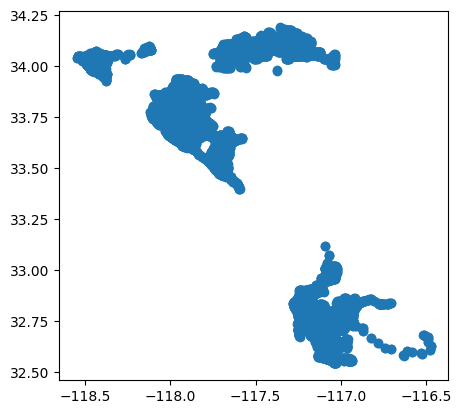

In [31]:
map1 = stops.plot()
map1

In [ ]:
# To add styleguide
from shared_utils import styleguide
from shared_utils import calitp_color_palette as cp